In [44]:
%matplotlib inline
%tb
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

SystemExit: 1

In [45]:
import numpy as np
import pandas as pd

In [46]:
import datetime as dt

In [47]:
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)
m_columns = inspector.get_columns("measurement")
m_columns = [x["name"] for x in m_columns]
s_columns = inspector.get_columns("station")
s_columns = [x["name"] for x in s_columns]
print("measurement:", m_columns)
print("station:", s_columns)

measurement: ['id', 'station', 'date', 'prcp', 'tobs']
station: ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [61]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# sort date desc and grab first result
precip_results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(precip_results[0], "%Y-%m-%d")

# get start date by subtracting 1 from year.
# this could have issues during leap years, but I am ignoring that for now.
start_date = dt.datetime(last_date.year - 1, last_date.month, last_date.day).date()

# Perform a query to retrieve the data and precipitation scores
precip_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= start_date).all()

# place results in dataframe
precip_df = pd.DataFrame(precip_results, columns = ["Date", "Precipitation"]).set_index("Date").dropna()

# Sort the dataframe by date
precip_df = precip_df.sort_values("Date")

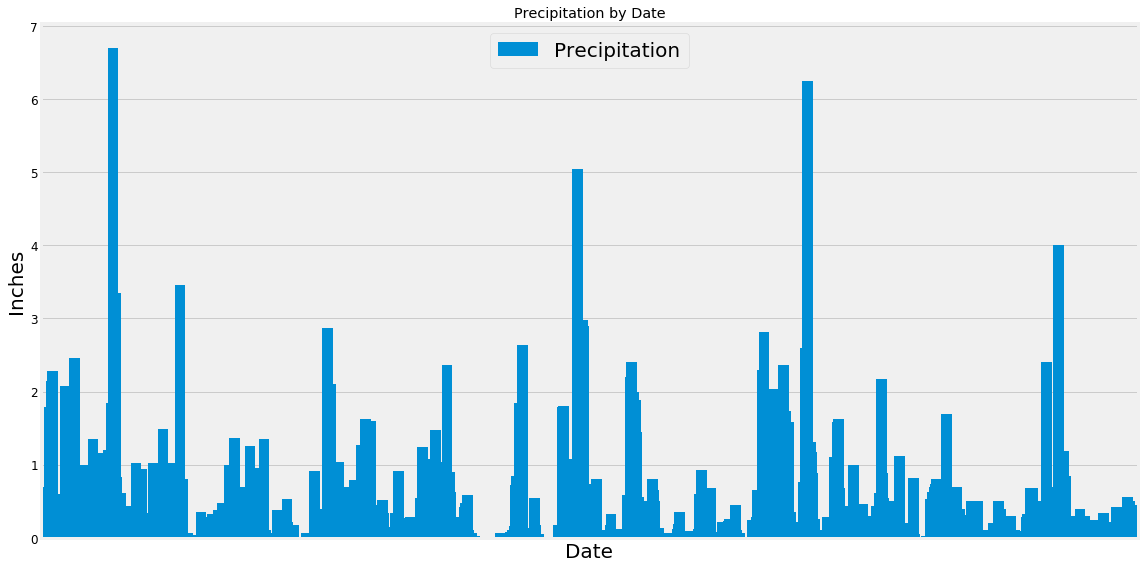

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind="bar", width=20, title="Precipitation by Date",
               figsize=(16,8), legend=True, fontsize=12, grid=True)
plt.legend(loc='upper center', fontsize='20')

# Remove xtick for every data measurement.
# there are thousands and it gets messy
plt.xticks([])

plt.xlabel("Date", fontsize=20)
plt.ylabel("Inches", fontsize=20)

plt.tight_layout()
plt.show()

In [28]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [29]:
# Design a query to show how many stations are available in this dataset?
station_results = session.query(func.count(Station.station)).all()
station_results

[(9)]

In [30]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# group by stations, count temperature observations per station, sort descending
station_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# most active station is first result from above
station_most_active = station_count[0][0]

# query requested stats, filtering by most active station
station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_most_active).all()
station_temps

[(54.0, 85.0, 71.66378066378067)]

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# query temperature readings for last year, based on start date calculated earlier in notebook
station_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == station_most_active).\
    filter(Measurement.date >= start_date).all()

# convert to a dataframe
station_df = pd.DataFrame(station_tobs)

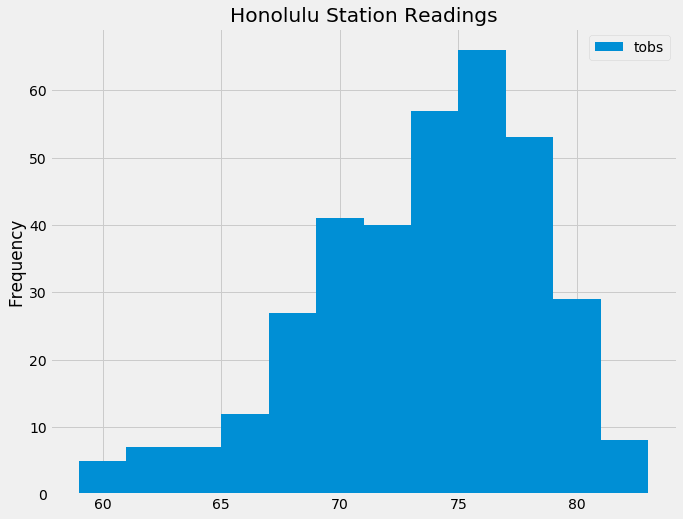

In [65]:
# create histogram of dataframe, with 12 bins
station_df["tobs"].plot(kind="hist", figsize=(10, 8), title="Honolulu Station Readings", legend=True, bins=12)
plt.show()

In [48]:
# create a flask app
app = Flask(__name__)

In [49]:
# create home page
@app.route("/")
def home():
    print("Server received request for 'Home' page...")
    return (
        "Welcome to the Honolulu weather measurements API!<br>"
        "/api/v1.0/precipitation"
        "/api/v1.0/stations"
        "/api/v1.0/tobs"
        "/api/v1.0/<start>"
        "/api/v1.0/<start>/<end>"
    )

In [50]:
# run the flask page
if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

C:\Users\monol\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
